# Check GPUs and Install libraries

In [1]:
#@title 1.1 Check GPU Status
import subprocess
simple_nvidia_smi_display = True#@param {type:"boolean"}
if simple_nvidia_smi_display:
  #!nvidia-smi
  nvidiasmi_output = subprocess.run(['nvidia-smi', '-L'], stdout=subprocess.PIPE).stdout.decode('utf-8')
  print(nvidiasmi_output)
else:
  #!nvidia-smi -i 0 -e 0
  nvidiasmi_output = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE).stdout.decode('utf-8')
  print(nvidiasmi_output)
  nvidiasmi_ecc_note = subprocess.run(['nvidia-smi', '-i', '0', '-e', '0'], stdout=subprocess.PIPE).stdout.decode('utf-8')
  print(nvidiasmi_ecc_note)

GPU 0: NVIDIA L4 (UUID: GPU-75284cda-bad1-fb4b-9e7a-bbfd92ac0a60)



# Imports

In [1]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
from datasets import Dataset as HFDataset

from peft import LoraConfig, get_peft_model
from datasets import load_dataset

from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    BertConfig,
    BertModel,
    Trainer,
    TrainingArguments,
    T5Tokenizer,
    T5ForConditionalGeneration,
    AutoTokenizer, 
    AutoModelForCausalLM,
    GPT2Model,
    GPT2Config,
    GPT2ForSequenceClassification,
    GPT2Tokenizer,
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define custom dataset class

In [2]:
# Define custom dataset class
class MyDataset(Dataset):
    def __init__(self, codebase_path, pair_path):
        # Load data
        self.codebase = pd.read_csv(codebase_path)
        self.pair_data = pd.read_csv(pair_path)

        # Create a dictionary to map code_id to Java code for fast lookup
        self.code_dict = dict(zip(self.codebase['id'], self.codebase['code']))

    def __len__(self):
        return len(self.pair_data)

    def __getitem__(self, idx):
        # Get pair data
        row = self.pair_data.iloc[idx]
        code_id_1 = row['code_id_1']
        code_id_2 = row['code_id_2']
        label = row['label']

        # Retrieve the Java methods using code_id
        code1 = self.code_dict[code_id_1]
        code2 = self.code_dict[code_id_2]

        # Return input and label
        return {
            'code1': code1,
            'code2': code2,
            'label': label
        }

# Data pre-processing

In [3]:
# File paths
codebase_file = 'MutantBench/codebase.csv'
train_file = 'MutantBench/train.csv'
test_file = 'MutantBench/test.csv'

raw_train_dataset = MyDataset(
        codebase_path=codebase_file,
        pair_path=train_file,
      )

raw_test_dataset = MyDataset(
        codebase_path=codebase_file,
        pair_path=test_file,
      )

# Convert MyDataset to Hugging Face Dataset
train_data_dict = [{'code1': item['code1'], 'code2': item['code2'], 'label': item['label']} for item in raw_train_dataset]
test_data_dict = [{'code1': item['code1'], 'code2': item['code2'], 'label': item['label']} for item in raw_test_dataset]
train_hf_dataset = HFDataset.from_list(train_data_dict)
test_hf_dataset = HFDataset.from_list(test_data_dict)

In [4]:
# Convert to Pandas DataFrame for easier manipulation
df = test_hf_dataset.to_pandas()

# Specify the column for stratification
label_column = "label"  # Replace with the correct column name for stratification
if label_column not in df.columns:
    raise ValueError(f"Column '{label_column}' not found in the dataset.")

# Stratified sampling using sklearn
# Adjust the test_size to control the size of the sub-dataset

sub_validation, sub_test = train_test_split(df, stratify=df[label_column], test_size=0.5, random_state=42) # test

# Convert back to a Hugging Face Dataset (optional)
sub_validation_dataset = HFDataset.from_pandas(sub_validation)
sub_test_dataset = HFDataset.from_pandas(sub_test)

# Output the sub-dataset
print(sub_validation_dataset)
print(sub_test_dataset)

Dataset({
    features: ['code1', 'code2', 'label', '__index_level_0__'],
    num_rows: 825
})
Dataset({
    features: ['code1', 'code2', 'label', '__index_level_0__'],
    num_rows: 825
})


In [5]:
# train_hf_dataset.save_to_disk("SubMutantBench_train")
# sub_validation_dataset.save_to_disk("SubMutantBench_validation")
# sub_test_dataset.save_to_disk("SubMutantBench_test")

Saving the dataset (0/1 shards):   0%|          | 0/1652 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/825 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/825 [00:00<?, ? examples/s]

In [2]:
train_hf_dataset = HFDataset.load_from_disk("SubMutantBench_train")
validation_hf_dataset = HFDataset.load_from_disk("SubMutantBench_validation")
test_hf_dataset = HFDataset.load_from_disk("SubMutantBench_test")
print(train_hf_dataset)
print(validation_hf_dataset)
print(test_hf_dataset)

Dataset({
    features: ['code1', 'code2', 'label'],
    num_rows: 1652
})
Dataset({
    features: ['code1', 'code2', 'label', '__index_level_0__'],
    num_rows: 825
})
Dataset({
    features: ['code1', 'code2', 'label', '__index_level_0__'],
    num_rows: 825
})


In [3]:
# Pre-process the original data
def preprocess_function(examples):
    inputs = ["code_1: " + examples["code1"][i] + " code_2: " + examples["code2"][i] for i in range(len(examples["code1"]))]
    targets = [i for i in examples["label"]]
    # targets = [str(i) for i in examples["label"]]
    
    max_length = 512
    return {"input_ids": tokenizer(inputs, truncation=True, padding="max_length", max_length=max_length)["input_ids"],
            "attention_mask": tokenizer(inputs, truncation=True, padding="max_length", max_length=max_length)["attention_mask"],
            "labels": torch.tensor(targets, dtype=torch.long),
            # "labels": tokenizer(targets, truncation=True, padding="max_length", max_length=256)["input_ids"]
        }

configuration = GPT2Config()

# Load the Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("microsoft/CodeGPT-small-java-adaptedGPT2")
tokenizer.pad_token = tokenizer.eos_token  # Or assign a suitable token

# Pre-process data
tokenized_train_dataset = train_hf_dataset.map(preprocess_function, batched=True, batch_size=4)
tokenized_validation_dataset = validation_hf_dataset.map(preprocess_function, batched=True, batch_size=4)
tokenized_test_dataset = test_hf_dataset.map(preprocess_function, batched=True, batch_size=4)

Map:   0%|          | 0/1652 [00:00<?, ? examples/s]

Map:   0%|          | 0/825 [00:00<?, ? examples/s]

Map:   0%|          | 0/825 [00:00<?, ? examples/s]

In [4]:
print(train_hf_dataset)
print(validation_hf_dataset)
print(test_hf_dataset)

Dataset({
    features: ['code1', 'code2', 'label'],
    num_rows: 1652
})
Dataset({
    features: ['code1', 'code2', 'label', '__index_level_0__'],
    num_rows: 825
})
Dataset({
    features: ['code1', 'code2', 'label', '__index_level_0__'],
    num_rows: 825
})


Token indices sequence length is longer than the specified maximum sequence length for this model (2630 > 1024). Running this sequence through the model will result in indexing errors


Total code snippets: 1652
Average token length: 481.55
Max token length: 2630
Min token length: 21


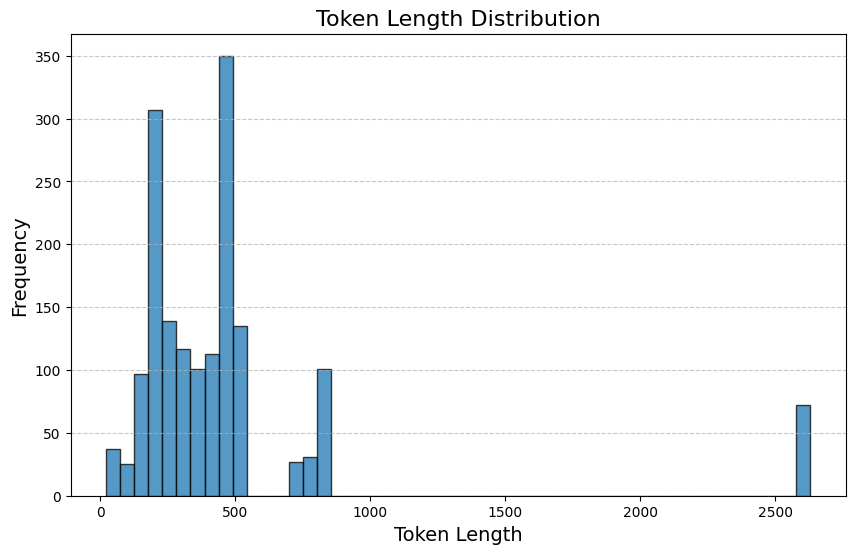

In [5]:
# Load your dataset
def load_dataset(file_path):
    """
    Load a dataset (CSV or JSON) into a Pandas DataFrame.
    Modify this function to support other formats.
    """
    if file_path.endswith(".csv"):
        return pd.read_csv(file_path)
    elif file_path.endswith(".json"):
        return pd.read_json(file_path)
    else:
        raise ValueError("Unsupported file format. Use CSV or JSON.")

# Tokenize the code and calculate token lengths
def analyze_token_distribution(dataset, code_column, tokenizer_name="gpt2"):
    """
    Analyze token distribution for a specified column containing code.
    
    Args:
        dataset (pd.DataFrame): The dataset containing code.
        code_column (str): The name of the column containing code snippets.
        tokenizer_name (str): The name of the tokenizer (e.g., 'gpt2').
    
    Returns:
        token_lengths (list): List of token lengths for each code snippet.
    """
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    token_lengths = []
    for code_snippet in dataset[code_column]:
        if isinstance(code_snippet, str):  # Ensure the snippet is a string
            tokens = tokenizer.encode(code_snippet, truncation=False, add_special_tokens=False)
            token_lengths.append(len(tokens))
    
    return token_lengths

# Visualize token length distribution
def plot_token_distribution(token_lengths):
    """
    Plot the distribution of token lengths.
    
    Args:
        token_lengths (list): List of token lengths.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(token_lengths, bins=50, alpha=0.75, edgecolor='black')
    plt.title("Token Length Distribution", fontsize=16)
    plt.xlabel("Token Length", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# # Path to your dataset
# file_path = "MutantBench/codebase.csv"  # Replace with your dataset file path
code_column = "code1"  # Replace with the name of the column containing code

# # Load dataset
# dataset = load_dataset(file_path)

# Analyze token distribution
token_lengths = analyze_token_distribution(train_hf_dataset, code_column, tokenizer_name="gpt2")
# token_lengths = analyze_token_distribution(sub_validation_dataset, code_column, tokenizer_name="gpt2")
# token_lengths = analyze_token_distribution(sub_test_dataset, code_column, tokenizer_name="gpt2")

# Print basic statistics
print(f"Total code snippets: {len(token_lengths)}")
print(f"Average token length: {sum(token_lengths) / len(token_lengths):.2f}")
print(f"Max token length: {max(token_lengths)}")
print(f"Min token length: {min(token_lengths)}")

# Visualize token distribution
plot_token_distribution(token_lengths)

In [5]:
# Load pre-trained model
num_labels = 2
model = GPT2ForSequenceClassification(configuration).from_pretrained("microsoft/CodeGPT-small-java-adaptedGPT2", num_labels=num_labels)
model.config.pad_token_id = model.config.eos_token_id
# Config LoRA specifications
lora_config = LoraConfig(
    # r=8,  # lower the rank
    r=48,  # lower the rank
    lora_alpha=32,
    # target_modules=["q", "v"],  # apply LoRA to q and v of attention modules
    target_modules=["c_attn"],  # target query, key, and value together
    lora_dropout=0.1,
    bias="none",
    # task_type="SEQ_2_SEQ_LM",  # task type set to seq2seq generation
    task_type="SEQ_CLS",  # task type set to text classification
)

# Convert the model to LoRA model
model = get_peft_model(model, lora_config)

# Check the number of trainable parameters (for LoRA)
model.print_trainable_parameters()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/CodeGPT-small-java-adaptedGPT2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,771,008 || all params: 126,214,656 || trainable%: 1.4032


/opt/conda/envs/pytorch/lib/python3.10/site-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [6]:
# Adjust the batch size
batch_size = 4
training_args = TrainingArguments(
    output_dir="./results/lora-codeGPT-emd",
    eval_strategy="epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    metric_for_best_model="f1",
    weight_decay=0.01,
    num_train_epochs=6,
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    report_to="mlflow",  # disable wandb etc.
    fp16=True,  # mixed precision training
    optim="adamw_torch",  # use torch original optimizer
)

def compute_metrics(pred):
    labels = pred.label_ids
    # Extract logits from the predictions & assuming logits are the first element in the tuple
    logits = pred.predictions[0] if isinstance(pred.predictions, tuple) else pred.predictions
    preds = logits.argmax(-1)
    f1 = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="macro")
    recall = recall_score(labels, preds, average="macro")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_validation_dataset,
)

# Start Training
trainer.train()

# Save the model after LoRA fine-tuing
model.save_pretrained("./lora-codeGPT-emd/model")
tokenizer.save_pretrained("./lora-codeGPT-emd/tokenizer")

print("LoRA fine-tuning done, model saved!")

test_results = trainer.predict(tokenized_test_dataset)
predictions, labels, metrics = test_results
print(metrics)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.190800,0.502954,0.909091,0.912582,0.716429,0.771700
2,0.148300,0.487811,0.921212,0.957516,0.740000,0.802140
3,0.272800,0.440401,0.921212,0.957516,0.740000,0.802140
4,0.290500,0.419062,0.921212,0.957516,0.740000,0.802140
5,0.268800,0.409767,0.921212,0.957516,0.740000,0.802140
6,0.776900,0.428175,0.921212,0.957516,0.740000,0.802140


LoRA fine-tuning done, model saved!


{'test_loss': 0.37453630566596985, 'test_accuracy': 0.9321212121212121, 'test_precision': 0.9630118890356671, 'test_recall': 0.7741935483870968, 'test_f1': 0.8349622770919067, 'test_runtime': 10.4825, 'test_samples_per_second': 78.703, 'test_steps_per_second': 19.747}
